<a href="https://colab.research.google.com/github/steflhermitte/EO-Notebooks/blob/master/PythonProgramming/RS_Notebook2_Loading_RS_data_in_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[<img src="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" width="200" align='right'>](https://www.tudelft.nl/citg/over-faculteit/afdelingen/geoscience-remote-sensing/staff/scientific-staff/dr-stef-lhermitte)


# Loading remote sensing data in python 
*Created by Stef Lhermitte (s.lhermitte at tudelft.nl / [@steflhermitte](https://twitter.com/StefLhermitte) | www.earthmapps.io)*

*with inspiration and fragments from:*

* [geemap.org](https://geemap.org/)
* [Google Earth Engine guide](https://developers.google.com/earth-engine/guides)
* [rasterio](https://rasterio.readthedocs.io/en/latest/)


[![Twitter](https://img.shields.io/twitter/url/https/twitter.com/cloudposse.svg?style=social&label=%20%40steflhermitte)](https://twitter.com/steflhermitte)





## Introduction
In this notebook we will learn how to download remote sensing data from Google Earth engine and open them in python using rasterio. After opening the data, we should be able to do multiple types of analyses on the data.

In order to use run this notebook you will need a Google Earth Engine account. If you do not have one yet, create one at [GEE webpage](https://signup.earthengine.google.com/#!/). Google Earth Engine combines a multi-petabyte [catalog](https://developers.google.com/earth-engine/datasets/) of satellite imagery and geospatial datasets with planetary-scale analysis capabilities and makes it available for scientists, researchers, and developers to detect changes, map trends, and quantify differences on the Earth's surface. The public data archive includes more than thirty years of historical imagery and scientific datasets, updated and expanded daily. It contains over twenty petabytes of geospatial data instantly available for analysis.

In this notebook, we will limit the use of GEE and `geemap` to downloading different data sources. GEE offers a multitude of more opportunities and functions to process, analyze and visualize the data in the cloud, but covering these is beyond the scope of this notebook. If you want to know more about GEE functionalities I recommend the excellent [GEE](https://developers.google.com/earth-engine/guides) and [geemap](https://geemap.org/) tutorials and welcome you always in our [Remote Sensing & Big Data course](https://studiegids.tudelft.nl/a101_displayCourse.do?course_id=56333) where all these aspects are covered in more detail.




## Before you start
Before starting this notebook make sure that you installed the necessary packages (see [Python installation example notebook](https://colab.research.google.com/drive/1MccJkybH3jEDeQ8GkU7NmtbXP8ZE4V5M?usp=sharing)). For your local computer, you only need to install the packages once and you won't need the next cell. For Colab, you need to run the following installation steps every time you start a new notebook and restart the environment afterwards. 

In [ ]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
# !pip install cython
# !pip install git+https://github.com/SciTools/cartopy.git --no-binary cartopy
# !apt-get -qq install python-cartopy python3-cartopy
!pip install cartopy geemap
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely
!pip install matplotlib-scalebar
!pip install pyepsg
!pip install owslib
!pip install scikit-learn
!pip install geopandas
!pip install rasterio
!pip install geemap
from google.colab import drive
drive.mount('/content/drive')

If you are missing the `glob2` and `imageio` package on your local computer, you can just install it by running:

In [ ]:
%pip install glob2 imageio

For colab users: don't forget to restart your runtime after installation to avoid problems with matplotlib.

## Load the necessary packages

We start by importing the necessary packages

In [ ]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import geemap
import rasterio
import ee
import geemap
import os
import shutil
import numpy as np
import pandas as pd
import glob2
import imageio
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 12] # to make the default figures larger

Now you need to authenticate Google Earth Engine and launch it in colab.



In [ ]:
## Authenticate EE
ee.Authenticate()

In [ ]:
# Launch EE
ee.Initialize()

## Accessing your local/colab storage and file structure
Within this notebook you will be saving data to your computer (or colab storage) and subsequently reading it in again (e.g. for analysis). Therefore, you need to have a basic understanding of how to access your folder/file system. Typically the reading and writing functions just take string arguments (e.g. `'/drive/folder1/subfolder1/file1.jpg'`) as inputs, but the way they are formulated might differ between Windows/Mac/Linux/Colab. Windows subfolders are separated by `\` and on Mac/Linux/Colab by `/` (e.g. Downloads/subfolder1/subsubfolder2/). Since `\` is a special character you often need to type it twice. To get an idea on how it looks on your computer You can check your current directory with `os.getcwd` (i.e., get. Current Working Directory).

In [ ]:
os.getcwd()

Subsequently, we can define our own folders. For example, if we want the test subfolder in our Downloads directory you can define that folder manually or by using a `os.path.join` function.



In [ ]:
# Get your home directory
home = os.path.expanduser('~')
# Define folder manually
out_dir = home + '/Downloads/test' # On Mac/Linux
print(out_dir)
out_dir = home + '\\Downloads\\test' # On Windows
print(out_dir)
# Or use the os.path.join function to adapt to your computer environment
out_dir = os.path.join(home, 'Downloads','test')
print(out_dir)

We can also use regular expressions to look for files that fullfill certain criteria. If we use `glob2.glob` we can search for a certain pattern in our filees and return a list of filenames. Within such search criteria `*` is a important character as it means "match any character zero or many times". 

In [ ]:
# Without *: should give no output as we did not define any character
glob2.glob('/content/sample_data/')

In [ ]:
# With *: should give you a list of all files in this folder
glob2.glob('/content/sample_data/*')

Using this pattern, we can search for files with a certain pattern. For example, if we only want the files with a certain extension or starting characters:

In [ ]:
# With *.extension: should give only files with .csv extension
glob2.glob('/content/sample_data/*.csv')

In [ ]:
# Should give only files with starting with mnist and with .csv extension
glob2.glob('/content/sample_data/mnist*.csv')

## geemap
geemap is a Python package for interactive mapping with Google Earth Engine (GEE). During the past few years, GEE has become very popular in the geospatial community and it has empowered numerous environmental applications at local, regional, and global scales. GEE provides both JavaScript and Python APIs for making computational requests to the Earth Engine servers. Compared with the comprehensive documentation and interactive IDE (i.e., GEE JavaScript Code Editor) of the GEE JavaScript API, the GEE Python API has relatively little documentation and limited functionality for visualizing results interactively. The geemap Python package was created to fill this gap. It is built upon ipyleaflet and ipywidgets, and enables users to analyze and visualize Earth Engine datasets interactively within a Jupyter-based environment. The ipyleaflet or folium interface allows moreover to visualize geospatial data dynamically, allowing to zoom/pan etc.

For example, by running the following cell we will initiate an interactive ipyleaflet map.

In [ ]:
Map = geemap.Map()
Map

At the moment this Map is still empty as we did not add any data to it, but we can do that easily using different approaches. 


### Basemaps 
For example we can add different basemaps (see https://geemap.org/basemaps/), which we can toggle in the right corner using the icon 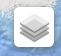 

In [ ]:
Map = geemap.Map()
Map.add_basemap('SATELLITE')
Map.add_basemap('ROADMAP')
Map.add_basemap('Esri Ocean')
Map.add_basemap('Esri National Geographic')
Map

### WMS
Or we can add WMS and XYZ tile layers:

In [ ]:
Map = geemap.Map()
# Add XYZ tiles
url = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}'
Map.add_tile_layer(url, name='Google Map', attribution='Google')
# Add WMS tiles
naip_url = 'https://services.nationalmap.gov/arcgis/services/USGSNAIPImagery/ImageServer/WMSServer?'
Map.add_wms_layer(url=naip_url, layers='0', name='NAIP Imagery', format='image/png', shown=True)
# For example last weeks example MODIS example
wv_url = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi'
Map.add_wms_layer(url=wv_url,layers='VIIRS_SNPP_CorrectedReflectance_TrueColor',time='2021-04-01', name='MODIS')
# Or the PDOK imagery
pd_url = 'https://service.pdok.nl/hwh/luchtfotorgb/wms/v1_0'
Map.add_wms_layer(url=pd_url,layers='Actueel_ortho25',name='PDOK',shown=False)
Map

### GEE data
Or we can add GEE data ranging from images/image collections to geometries/features/feature collections.



#### Images vs. image collections
When processing data it is important to understand the difference between images and image collections. 
[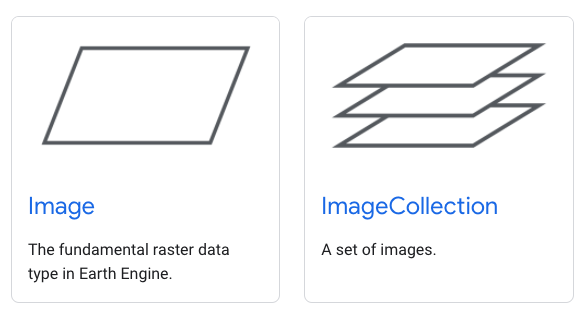](https://developers.google.com/earth-engine/guides/objects_methods_overview)

Images are individual rasters composed of one or more bands and each band has its own name, data type, scale, mask and projection. Each image has metadata stored as a set of properties. Images can be loaded by pasting an Earth Engine asset ID into the `ee.Image()` constructor. You can find image IDs in the [data catalog](https://developers.google.com/earth-engine/datasets). For example, to load the USGS SRTM:

In [ ]:
# Define Earth Engine dataset
image = ee.Image('USGS/SRTMGL1_003')

Subsequently, we can add it to our Map by defining some visualization parameters. Here we are going to define only the min/max value to visualize, but you can find additional visualisation parameters [here](https://developers.google.com/earth-engine/guides/image_visualization).

In [ ]:
# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 4000}

# Create Map
Map = geemap.Map()

# Add Earth Engine layers to Map
Map.addLayer(image, vis_params, 'DEM')

# Show map
Map

An ImageCollection is a stack or sequence of images. For example, it can be the entire [Sentinel-2 surface reflection collection]('https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR') which contains all Sentinel-2 surface reflectance images over the Earth.

An ImageCollection can be loaded by pasting an Earth Engine asset ID into the `ee.ImageCollection` constructor. You can find ImageCollection IDs in the [data catalog](https://developers.google.com/earth-engine/datasets). 

In [ ]:
sentinelCollection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

This collection contains every Sentinel-2 image in the public catalog. There are a lot. Usually you want to filter the collection before. Filtering can occur based on:
 * region of interest / bounds:  to only get images that contain a certain area. Later we will see how to define such an area
 * date: to only get images from a certain date range
 * metadata: to only get images that fulfill a certain metadata requirement (e.g. only images with less than x% cloud cover). To get an idea of the potential metadata, I recommend to have a look at the data catalog -> `Image Properties` for each collection (e.g. for S2: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR)

In [ ]:
S2 = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
         .filterBounds(ee.Geometry.Point(4, 52))
         .filterDate('2019-01-01', '2019-12-31')
         .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',20))

The standard way to get an image out of a collection is to reduce the collection. For example, we can sort based on a metadata field and subsequently get the first image. Notice in the following example that the image appears very dark as the min/max values are 0/10000 (corresponding to relfectance values of 0/1; see scale parameter in [data catalog](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR#bands)), but changing the max-value to a lower valuye will make it clearer.

In [ ]:
# Sort and get first image
S2_im = S2.sort('CLOUDY_PIXEL_PERCENTAGE').first()
# Define vis parameters
S2_vis = {'bands':['B4','B3','B2'],
          'min':0,
          'max':10000}
# Initialize Map
Map = geemap.Map()
# Add image
Map.addLayer(S2_im,S2_vis,'S2 first image')
# Zoom map on image on scale level 10
Map.center_object(S2_im,10)

Map

Or apply some basic reduces to get the mean, median etc.

In [ ]:
# Get the Mean image of the collection
S2_im = S2.mean()
# Get the Median image of the collection
S2_im2 = S2.median()

# Define vis parameters
S2_vis = {'bands':['B4','B3','B2'],
          'min':0,
          'max':4000}
# Initialize Map
Map = geemap.Map()
# Add image
Map.addLayer(S2_im,S2_vis,'S2 mean')
Map.addLayer(S2_im2,S2_vis,'S2 median')
Map


As you will notice, the `mean` and `median` image are rather different. Can you explain these differences?

#### Geometries in GEE
We can also define geometries in GEE as Earth Engine handles vector data with the Geometry type. GEE support points and polygons but in this example notebook we are going to limit ourselves to points and rectangles. By default these are defined in `EPSG:4326` so lat/lon coordinates. Subsequently we can use these geometries to filter our data or define an output geometry when exporting

In [ ]:
# Point based on lon/lat
point = ee.Geometry.Point([1.5, 1.5])
# Rectangle based on (minLon, minLat, maxLon, maxLat).
rectangle = ee.Geometry.Rectangle([4.30,51.95,4.39,52])
# rectangle = ee.Geometry.Rectangle([4.38,51.2,4.9,52])

### Exporting from GEE
geemap also allows to export your data to your local computer using the `.ee_export_image` (for images) and `ee_export_image_collection` (for collections) functions.

To export, we always need to [define](https://geemap.org/common/#geemap.common.ee_export_image):
* `region`: a region of interest (bounding box)
*  `crs`: a coordinate reference system (i.e. projection where the data are exported in) 
* `scale`: the scale (in m) in which the data are exported
* `filename`: output filename for the exported image

To define a filename and folder structure, we need to consider the computer architecture we are working in (e.g., windows, Mac, Linux or Colab). If you are working on a local computer, you can get your local folder (e.g. `Downloads` folder) with:

In [ ]:
# If on local computer
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads','test')

If you want other specific folders, you can change the `Downloads` with your local folder. Remember that on Window subsfolder are separated by `\` and on Mac/Linux by `/` (e.g. `Downloads/subfolder1/subsubfolder2/`). Moreover Windows often prefers double `\` (`Downloads\\subfolder1\\subsubfolder2\\`).

On a colab computer mounted to Google drive, your output directory should be `/content/drive/MyDrive` with potential subfolders to save it to your Drive.

In [ ]:
# If on colab and you want to download to drive
#out_dir = '/content/drive/MyDrive/'
# If on colab and you want to download it to the notebook storage only
#out_dir = '/content/'

To define the output file, we need to append the desired output filename to the folder

In [ ]:
filename = os.path.join(out_dir, 'S2_SR.tif')
print(filename)

And then we can start exporting. When we set `file_per_band=False` all image bands will be exported in one file. If you set it to `True`, each band will be saved to a different file with the band name appended. To understand what the different bands mean, I always recommend to check the data catalog of GEE before exporting.

In [ ]:
geemap.ee_export_image(S2_im, filename=filename, scale=10, region=rectangle, file_per_band=False)

One of the drawbacks of GEE is that downloads are limited to ~33.5Mb and max 10000 pixel dimensions. To avoid hitting this limit, it is therefore wise to subset to only the bands you need by using the [`select` function](https://developers.google.com/earth-engine/apidocs/ee-image-select). For example, if you only want the RGB+NIR bands you can select `['B4','B3','B2','B8']`. Again I recommend to check the data catalog to understand what these bands mean.

If you hit the download limit it may also be wise to select/download per band.

In [ ]:
geemap.ee_export_image(S2_im.select(['B4','B3','B2','B8']), filename=filename, scale=10, region=rectangle, crs='EPSG:3857', file_per_band=False)

Alternatively we can also download image collections using [`ee_export_image_collection`](https://geemap.org/common/#geemap.common.ee_export_image_collection). It is similar to exporting images, but now you only provide a folder you will download every image in your collection.

In [ ]:
geemap.ee_export_image_collection(S2.select(['B4','B3','B2']), out_dir=out_dir, scale=10, region=rectangle, crs='EPSG:3857', file_per_band=False)

## Rasterio
Once the data are downloaded we can open them using `rasterio`. Rasterio reads and writes geospatial raster datasets. It employs GDAL under the hood for file I/O and raster formatting. Its functions typically accept and return Numpy ndarrays. Rasterio is designed to make working with geospatial raster data more productive and more fun.

Consider a GeoTIFF file named `S2_SR.tif` we just downloaded. We first need to open it with rasterio

In [ ]:
dataset = rasterio.open(filename)

Rasterio’s open() function takes a path string or path-like object and returns an opened dataset object. The path may point to a file of any supported raster format. Rasterio will open it using the proper GDAL format driver. Dataset objects have some of the same attributes as Python file objects.

In [ ]:
dataset.name

Properties of the raster data stored in the example GeoTIFF can be accessed through attributes of the opened dataset object. Dataset objects have bands and this example has a band count of 4 as our latest export were only RGB+NIR bands.

In [ ]:
dataset.count

A dataset band is an array of values representing the partial distribution of a single variable in 2-dimensional (2D) space. All band arrays of a dataset have the same number of rows and columns.

In [ ]:
print(dataset.width)
print(dataset.height)

### Raster georeferencing
A GIS raster dataset is different from an ordinary image; its elements (or “pixels”) are mapped to regions on the earth’s surface. Every pixels of a dataset is contained within a spatial bounding box. In this case it are the coordinates in the output `crs` we defined when exporting.



In [ ]:
dataset.bounds

In [ ]:
dataset.crs

### Reading raster data
Data from a raster band can be accessed by the band’s index number. Following the GDAL convention, bands are indexed from 1 (and not 0 as in most python arrays)

In [ ]:
band1 = dataset.read(1)

The read() method returns a Numpy N-D array.

In [ ]:
band1

Instead of reading single bands, all bands of the input dataset can also be read into a 3-dimensonal ndarray. Note that the interpretation of the 3 axes is `(bands, rows, columns)`. 

In [ ]:
bands = dataset.read()
bands.shape

The interpretation of a 3-dimension array read from rasterio is `(bands, rows, columns)` while image processing software like scikit-image, pillow and matplotlib are generally ordered as `(rows, columns, bands)` where number of rows defines the dataset’s height, the columns are the dataset’s width.

Numpy provides a way to efficiently swap the axis order and you can use the following reshape functions to convert between raster and image axis order:



In [ ]:
from rasterio.plot import reshape_as_raster, reshape_as_image
# Convert to image
image = reshape_as_image(bands)
print(image.shape)
# Convert back to raster
raster = reshape_as_raster(image)
print(raster.shape)

Irrespective to the ordering, values from the array can be addressed by their `band, row, column` index. Notice that now indexing starts again at 0 as in classic python arrays

In [ ]:
bands[0, 150, 100]

## Analyzing & plotting the data
Once the data are downloaded and opened, we can start analyzing and plotting them. For example, if we want to calculate the calculate the `NDVI` (see lectures), we need the normalized ration between R & NIR, which in our case are bands 0 and 3.



In [ ]:
ndvi = (bands[3,:,:]-bands[0,:,:])/(bands[3,:,:]+bands[0,:,:])
ndvi

We can off course also plot the data in a map using the mapping tools you learned in notebook 1.

In [ ]:
plt.figure()
crs=ccrs.epsg(3857)
ax = plt.axes(projection=crs)
img_extent = [dataset.bounds.left,dataset.bounds.right,dataset.bounds.bottom,dataset.bounds.top]
ax.set_extent(img_extent,crs=crs)
ax.imshow(bands[0,:,:],vmin=0,vmax=3000, extent=img_extent, origin='upper')
scalebar = ScaleBar(1,box_alpha=0,color='white',location='lower right')
ax.add_artist(scalebar)

Or show it as an image using the reshape_as_image function and by rescaling the data to 0-1 range. Remember that the original data are integers that need rescaling to fit in the 0-1 range (see data catalog and scaling value)


Often this image is still rather dark. To understand why, you can plot a histogram of the band values.

In [ ]:
# First rescale the values to reflectance values
im = bands/10000. # see the data catalog where the scale value is 0.0001
# Plot
plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.hist(im[0,:,:].flatten(),bins=np.arange(0, 1, 0.01),color='red',alpha=0.3,label='R')
ax.hist(im[1,:,:].flatten(),bins=np.arange(0, 1, 0.01),color='green',alpha=0.3,label='G')
ax.hist(im[2,:,:].flatten(),bins=np.arange(0, 1, 0.01),color='blue',alpha=0.3,label='B')
ax.hist(im[3,:,:].flatten(),bins=np.arange(0, 1, 0.01),color='purple',alpha=0.3,label='NIR')
ax.legend(frameon=False,fontsize=10)
ax.set_xlabel('Surface reflectance []')
ax.set_ylabel('Probability density by counts')

The figure shows that for the RGB bands the reflectance values are indeed rather low (`<0.2`) resulting in a dark image. If we plot a false color `NIR/R/G` composite, we can indeed see that most of the image turns red as a result of the stronger reflectance of vegetation in the NIR band.

If we want to adjust the scaling, we can just apply offset and scaling values to increase brightness or contrast (see lecture slides).

In [ ]:
scaling = 2
offset = 0
image = reshape_as_image(bands)/10000.*scaling + offset
plt.figure(figsize=(10,10))
crs=ccrs.epsg(3857)
ax = plt.axes(projection=crs)
img_extent = [dataset.bounds.left,dataset.bounds.right,dataset.bounds.bottom,dataset.bounds.top]
ax.set_extent(img_extent,crs=crs)
ax.imshow(image[:,:,0:3], extent=img_extent, origin='upper')
scalebar = ScaleBar(1,box_alpha=0,color='white',location='lower right')
ax.add_artist(scalebar)

When  we can visualize one image, we can off course also visualize change. This can be done just making different subplots  and showing different images next to eachother, but also by making an animation (not covered in this notebook). 

First start by looping over all downloaded images. We can use this by using the `glob2` function which allows to search for all files that correspond to a certain filename. For example, if we want all `tif` files in our `out_dir` we can do:

In [ ]:
glob2.glob(os.path.join(out_dir, '*tif'))

Or get only the files from our collection that start with a `2`.

In [ ]:
glob2.glob(os.path.join(out_dir, '2*tif'))

Subsequently, we can loop over these files.

Now we have plotted all images and saved them to a `png` file in our out_dir. As you will see, there are still some bad frames (e.g. containing missing data. We can then manually remove them (e.g. by deleting them) and the convert them into a gif.

# Done
With these ingredients, you should be able to do the analyses of Notebook 2. Good luck!